# 1. Dataset 살펴보기

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'
data_df = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_df.head()

In [ ]:
# 고객 아이디를 담고있는 컬럼 생성
def customer_id(x):
    return x.split('_')[0]

data_df['ID'] = data_df['ImageId'].apply(customer_id)
data_df.head()

In [ ]:
# 고객한명에 대한 데이터만 불러와 동영상으로 확인
def one_customer_data(data_df, index):
    customer = np.unique(data_df['ID'])[index] # 고객 아이디
    img_data_list = list(data_df[data_df['ID']==customer]["ImageId"])
    mask_data_list = list(data_df[data_df['ID']==customer]["MaskId"])
    
    return customer, img_data_list, mask_data_list

index = 50
ID, img_data_list, mask_data_list = one_customer_data(data_df, index)

canvas = np.zeros(shape=(512,512*2+50,3), dtype=np.uint8)

for i in range(len(img_data_list)):
    img = cv2.imread(os.path.join(data_dir,'images' ,img_data_list[i]))
    mask = cv2.imread(os.path.join(data_dir,'masks' ,mask_data_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    thres = 240
    mask[mask<thres] = 0
    mask[mask>=thres] = 255

    canvas[:, :512, :] = img
    canvas[:,512+50:,:] = mask

    cv2.imshow('image', canvas)
    key = cv2.waitKey(60)
    if key == 27:
        break
    if key == ord('s'):
        cv2.waitKey(0)

cv2.destroyAllWindows()
    

# 2. 데이터셋 및 데이터 로더, transformer 구축

In [ ]:
import torch

In [ ]:
IMG_SIZE = 224

In [ ]:
# 데이터셋
class MY_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.img_dir = os.path.join(data_dir,phase,'images')
        self.mask_dir = os.path.join(data_dir,phase,'masks')
        self.img_file_list = [img for img in os.listdir(self.img_dir) if img.endswith('jpg')]
        self.mask_file_list = [mask for mask in os.listdir(self.mask_dir) if mask.endswith('jpg')]
        assert len(self.img_file_list) == len(self.mask_file_list) # 두 데이터의 길이가 다르면 오류

        self.transformer= transformer


    def __len__(self):
        return len(self.img_file_list)


    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.img_dir,self.img_file_list[index]))
        img = cv2.resize(img, dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_file_list[index]))
        mask = cv2.resize(mask, dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_NEAREST) #mask는 바이너리 형태로 되어있어야하기때문에 선형보간x

        # 마스크를 이진화 해줘야함
        mask[mask>=240] = 1
        mask[mask<240] = 0
        mask = mask/255.

        H,W,C = mask.shape
        background = np.ones((H,W,1)) #모든 채널이 label인 부분이 1, 아닌 부분이 0으로 설정 되어있음(이진화를 통해)
        background[mask[:,:,0] != 0] = 0 #각 채널이 label로 인식하고 있는 부분을 0으로 제외하기 위함
        background[mask[:,:,1] != 0] = 0
        background[mask[:,:,2] != 0] = 0

        mask = np.concatenate([background,mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False) #keepdims=True일 경우 argmax를 하더라도 채널이 압축되지 않음

        if self.transformer:
            img = self.transformer(img)
        
        #long() : classification을 pixel단위로 수행할것이기 때문에 integer로 변경(텐서로 변경하면 1. 과 같은 소수 형태로 나타나서, label은 정수임)
        mask = torch.from_numpy(mask).long()

        return img, mask
                         
        
        
        

In [ ]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation'
data_set = MY_Dataset(data_dir, 'train')
data_set[0] 

In [ ]:
#transformer 
from torchvision import transforms

def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.485,0.485],std=[0.229,0.224,0.225])])

    return transformer

In [ ]:
# DataLoader
from torch.utils.data import DataLoader

def build_dataloader(data_dir, batch_size):
    transformer = build_transformer()

    data_loaders = {}

    train_dataset = MY_Dataset(data_dir, phase='train', transformer=transformer)
    
    # 16000장의 데이터를 불러오는 데이터 로더 중 120장만 사용할 것이기 때문에 shuffle을 false로 -> True일 경우에 에폭마다 변경
    data_loaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    val_dataset = MY_Dataset(data_dir, phase='val', transformer=transformer)
    data_loaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return data_loaders

In [ ]:
# 구성 확인
data_dir = '../../data/MEDICAL-DATASET/Segmentation'
data_loaders = build_dataloader(data_dir, 6)

for phase in ['train','val']:
    for index, batch in enumerate(data_loaders[phase]):
        img = batch[0]
        mask = batch[1]

        print(f'{phase} img shape : {img.shape}')
        print(f'{phase} mask shape : {mask.shape}')

        if index == 0:
            break

# 3.Vgg16을 backbone으로 하여 U-Net 구현

In [ ]:
from torchvision import models

In [ ]:
# Vgg16 구성 살펴보기 -> U-Net의 layer구성과 vgg의 layer구성이 동일하기 때문에 backbone으로 사용이 가능
model = models.vgg16_bn(pretrained =False)
model

### U-Net

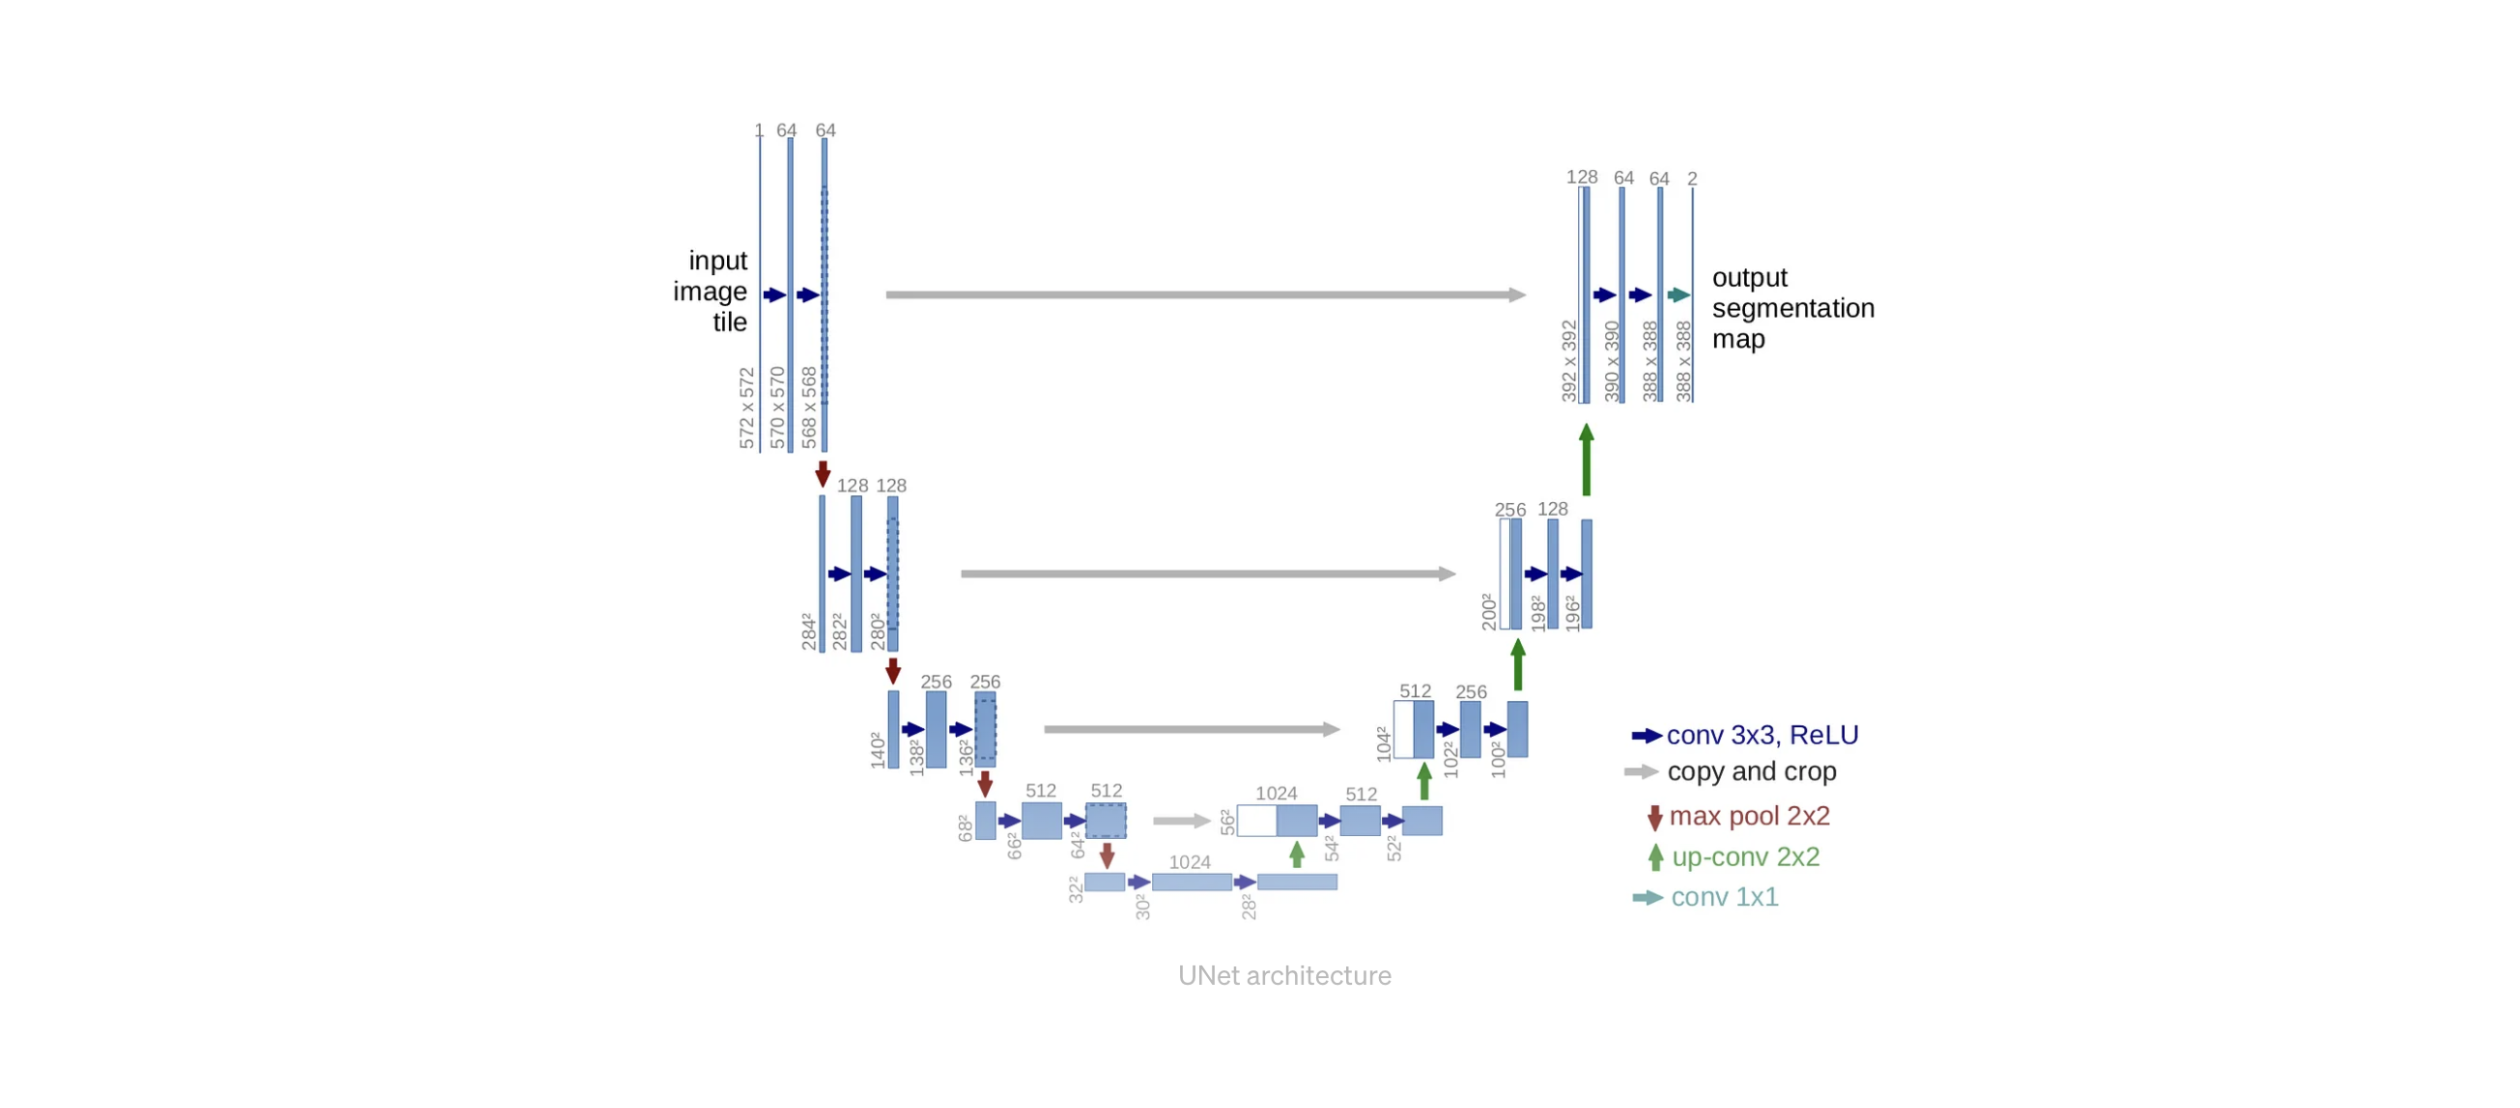

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# 파란색 화살표(convolution 연산)
def ConvLayer(in_channels, out_channels,kernel=3, padding=1):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True) #함수가 적용된 출력을 새로운 변수에 할당하는 대신 원래의 변수에 직접 덮어줌
    )
    return layer


# 디코더의 upconv(초록색)
def UpConvLayer(in_channels,out_channels):
    layer = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

    return layer

        

In [ ]:
# vgg를 활용한 encoder구현
class Encoder(nn.Module):
    def __init__(self, pretrained):
        super().__init__()

        backbone = models.vgg16_bn(pretrained=pretrained).features
        self.conv1 = nn.Sequential(*backbone[:6]) # *:가변인자 기호, 튜플로 값을 전달
        self.conv2 = nn.Sequential(*backbone[6:13])
        self.conv3 = nn.Sequential(*backbone[13:20])
        self.conv4 = nn.Sequential(*backbone[20:27])
        self.conv5 = nn.Sequential(*backbone[27:34],
                                    ConvLayer(512,1024,kernel=1,padding=0)) #Vgg에 512->1024는 구현이 안되어있어서 직접 구현

    def forward(self,x):
        encoder_feature = []
        
        out = self.conv1(x)
        encoder_feature.append(out)

        out = self.conv2(out)
        encoder_feature.append(out)

        out = self.conv3(out)
        encoder_feature.append(out)

        out = self.conv4(out)
        encoder_feature.append(out)

        out = self.conv5(out)

        return out, encoder_feature

In [ ]:
# Encoder의 작동 확인
encoder = Encoder(pretrained=False)
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)

for f in ftrs:
    print(f.shape)

print(out.shape)

In [ ]:
# 디코더 구성
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upconv1 = UpConvLayer(1024,512)
        self.conv1 = ConvLayer(512+512,512)

        self.upconv2 = UpConvLayer(512,256)
        self.conv2 = ConvLayer(256+256,256)

        self.upconv3 = UpConvLayer(256,128)
        self.conv3 = ConvLayer(128+128,128)

        self.upconv4 = UpConvLayer(128,64)
        self.conv4 = ConvLayer(64+64,64)

    def forward(self, x, encoder_feature):
        out = self.upconv1(x)
        out = torch.cat([out,encoder_feature[-1]],dim=1)
        out = self.conv1(out)

        out = self.upconv2(out)
        out = torch.cat([out,encoder_feature[-2]],dim=1)
        out = self.conv2(out)

        out = self.upconv3(out)
        out = torch.cat([out,encoder_feature[-3]],dim=1)
        out = self.conv3(out)

        out = self.upconv4(out)
        out = torch.cat([out,encoder_feature[-4]],dim=1)
        out = self.conv4(out)

        return out

In [ ]:
# decoder 작동 확인
encoder = Encoder(pretrained=False)
decoder = Decoder()

x = torch.rand(1,3,224,224)

out,ftrs = encoder(x)
out = decoder(out, ftrs)

print(out.shape)


In [ ]:
# encoder와 decoder, 마지막 64->class num을 합친 u-net구성

class U_Net(nn.Module):
    def __init__(self, num_classes, pretrained):
        super().__init__()
        self.encoder = Encoder(pretrained)
        self.decoder = Decoder()
        self.head = nn.Conv2d(64,num_classes, kernel_size=1)

    def forward(self, x):
        out, encoder_feature = self.encoder(x)
        out = self.decoder(out, encoder_feature)
        out = self.head(out)

        return out

In [ ]:
# 모델 구동 확인
model = U_Net(num_classes=4, pretrained=False)
x = torch.rand(1,3,224,224)
out = model(x)

print(out.shape)

# 4. Loss Function 구현 _crossentropy + dice

In [ ]:
import torch.nn.functional as F

In [ ]:
# dice_coeff 구하는법
# model을 통과한 예측값을 argmax로 한 차원으로 만들기 -> onehot -> 채널별 dice_coeff구하기(2*교집합/두 값의 합)

class UNet_Metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction='mean')

    def __call__(self, pred, target):
        oh_pred = F.one_hot(torch.argmax(pred, dim=1),num_classes=self.num_classes).permute(0,3,1,2)
        oh_target = F.one_hot(target, num_classes=self.num_classes).permute(0,3,1,2)

        dice_coefficient = self.batch_dice(oh_pred, oh_target)
        dice_loss = 1-dice_coefficient
        cross_loss = self.CE_loss(pred,target)

        total_loss = dice_loss+cross_loss

        return total_loss, dice_coefficient

    #batch당 dice
    def batch_dice(self, pred, target):
        batch_dice = 0
        batch = target.shape[0]

        for mini in range(batch):
            batch_dice += self.one_minibatch_dice(pred[mini],target[mini])

        return batch_dice/batch

    #미니배치의 class당 dice
    def one_minibatch_dice(self, pred, target):
        class_dice = 0

        for class_idx in range(1,self.num_classes):
            a = pred[class_idx]
            b = target[class_idx]

            inter = torch.sum(a.reshape(-1).float()*b.reshape(-1).float())
            set_sum = a.sum()+b.sum()

            if set_sum == 0:
                set_sum = 2*inter

            class_dice += (inter*2)/(set_sum+1e-9)

        return class_dice/(self.num_classes-1)
    

# 5. 학습코드 구현

In [ ]:
def train_one_epoch(dataloaders, model, criterion, optimizer):
    losses = {}
    dice_coefficients = {}

    for phase in ['train','val']:
        running_loss = 0.0
        running_dice_coeff = 0.0
        
        if phase == 'train':
            model.train()
        else : 
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):

            img = batch[0]
            target = batch[1]

            with torch.set_grad_enabled(phase=='train'):
                pred = model(img)
                batch_loss, batch_dice = criterion(pred,target)

                if phase == 'train':
                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

            running_loss += batch_loss.item()
            running_dice_coeff += batch_dice.item()

            if index == 10: #미니배치의 크기를 12로 해서 10번 돌려 120개만 학습하기위함
                break 

        losses[phase] = running_loss/index #10개의 배치만 보기 때문에 index로 나눠서 평균
        dice_coefficients[phase] = running_dice_coeff/index

    return losses, dice_coefficients
            

# 6. 모델의 학습
### weight initialization과 transfer learning 비교

#### 6-1 weight initialization

In [ ]:
# 모델 initialization을 위한 함수 -> he initialization
def He_initialization(module):
    if isinstance(module, nn.Conv2d): #입력받은 module이 conv2d의 클래스에 속하는 인스턴스라면 
        torch.nn.init.kaiming_normal_(module.weight) # Heinitialization, torch.nn.init.kaiming_normal_ : 가중치 텐서를 모델에 알아서 입력해줌
    elif isinstance(module, nn.BatchNorm2d): #입력받은 module이 batchnorm의 클래스에 속하는 인스턴스라면
        module.weight.data.fill_(1.0) #가중치 데이터를 1.0으로 초기화

In [ ]:
# 학습을 위한 데이터 생성
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'

NUMCLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = U_Net(num_classes=NUMCLASSES, pretrained=False)
#model.apply(He_initialization) #모델 가중치 초기화

criterion = UNet_Metric(num_classes=NUMCLASSES)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
# 모델 학습
num_epochs = 30

train_loss_d, val_loss_d = [],[]
train_dice_d, val_dice_d = [],[]

for epoch in range(num_epochs):
    losses,dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer)
    train_loss_d.append(losses['train'])
    val_loss_d.append(losses['val'])
    train_dice_d.append(dice_coefficients['train'])
    val_dice_d.append(dice_coefficients['val'])

    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")
    

#### 6-2 pretrained model

In [ ]:
# 학습을 위한 데이터 생성
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'

NUMCLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = U_Net(num_classes=NUMCLASSES, pretrained=True)
criterion = UNet_Metric(num_classes=NUMCLASSES)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
# 모델 학습
num_epochs = 30

train_loss_ptr, val_loss_ptr = [],[]
train_dice_ptr, val_dice_ptr = [],[]

for epoch in range(num_epochs):
    losses,dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer)
    train_loss_ptr.append(losses['train'])
    val_loss_ptr.append(losses['val'])
    train_dice_ptr.append(dice_coefficients['train'])
    val_dice_ptr.append(dice_coefficients['val'])

    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")

#### 6-4 pretrained model의 가중치는 고정, decoder의 가중치만 학습

In [ ]:
data_dir = '../../data/MEDICAL-DATASET/Segmentation/'

NUMCLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

model = U_Net(num_classes=NUMCLASSES, pretrained=True)
model.encoder.requires_grad_ = False #encoder부분의 grad를 계산하지 않도록 설정

criterion = UNet_Metric(num_classes=NUMCLASSES)
optimizer = torch.optim.SGD(filter(lambda p:p.requires_grad, model.parameters()),lr=0.001,momentum=0.9)
#filter(lambda p: p.requires_grad, model.parameters()) : model.parameter중에서 requires_grad가 True로 되어있는 부분만 걸러줌

In [ ]:
# 모델 학습
num_epochs = 30

train_loss_frz, val_loss_frz = [],[]
train_dice_frz, val_dice_frz = [],[]

for epoch in range(num_epochs):
    losses,dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer)
    train_loss_ptr.append(losses['train'])
    val_loss_ptr.append(losses['val'])
    train_dice_ptr.append(dice_coefficients['train'])
    val_dice_ptr.append(dice_coefficients['val'])

    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")